In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import utils.DataSplitter
import utils.Sklearn
from utils.ColumnEnum import Columns
from utils.metrics import *

In [2]:
level = 60
line = '1A'
target = Columns.target_passengersBoarding

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_level_line = df_level[df_level['line'] == line]
df_train, df_val = utils.DataSplitter.performTrainValSplit(df=df_level_line)

X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=[target, Columns.calendar_Q1, Columns.calendar_mon]) # avoid multicolinearity
y_train = df_train[target]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                         dropSpecific=[target, Columns.calendar_Q1, Columns.calendar_mon]) # avoid multicolinearity
y_val = df_val[target]

print(all(X_train.columns == X_val.columns))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.columns)

True
(14680, 27) (14680,) (1840, 27) (1840,)
Index(['peakHour', 'Q2', 'Q3', 'Q4', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',
       'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan', 'summerVacation',
       'fallVacation', 'christmasVacation', 'winterVacation', 'easterVacation',
       'acc_precip', 'bright_sunshine', 'mean_cloud_cover', 'mean_pressure',
       'mean_relative_hum', 'mean_temp', 'mean_wind_speed', 'snow_depth',
       'event'],
      dtype='object')


# Benchmark

## Seasonal naive with season 140 hours

Execution time: 0.003 sec


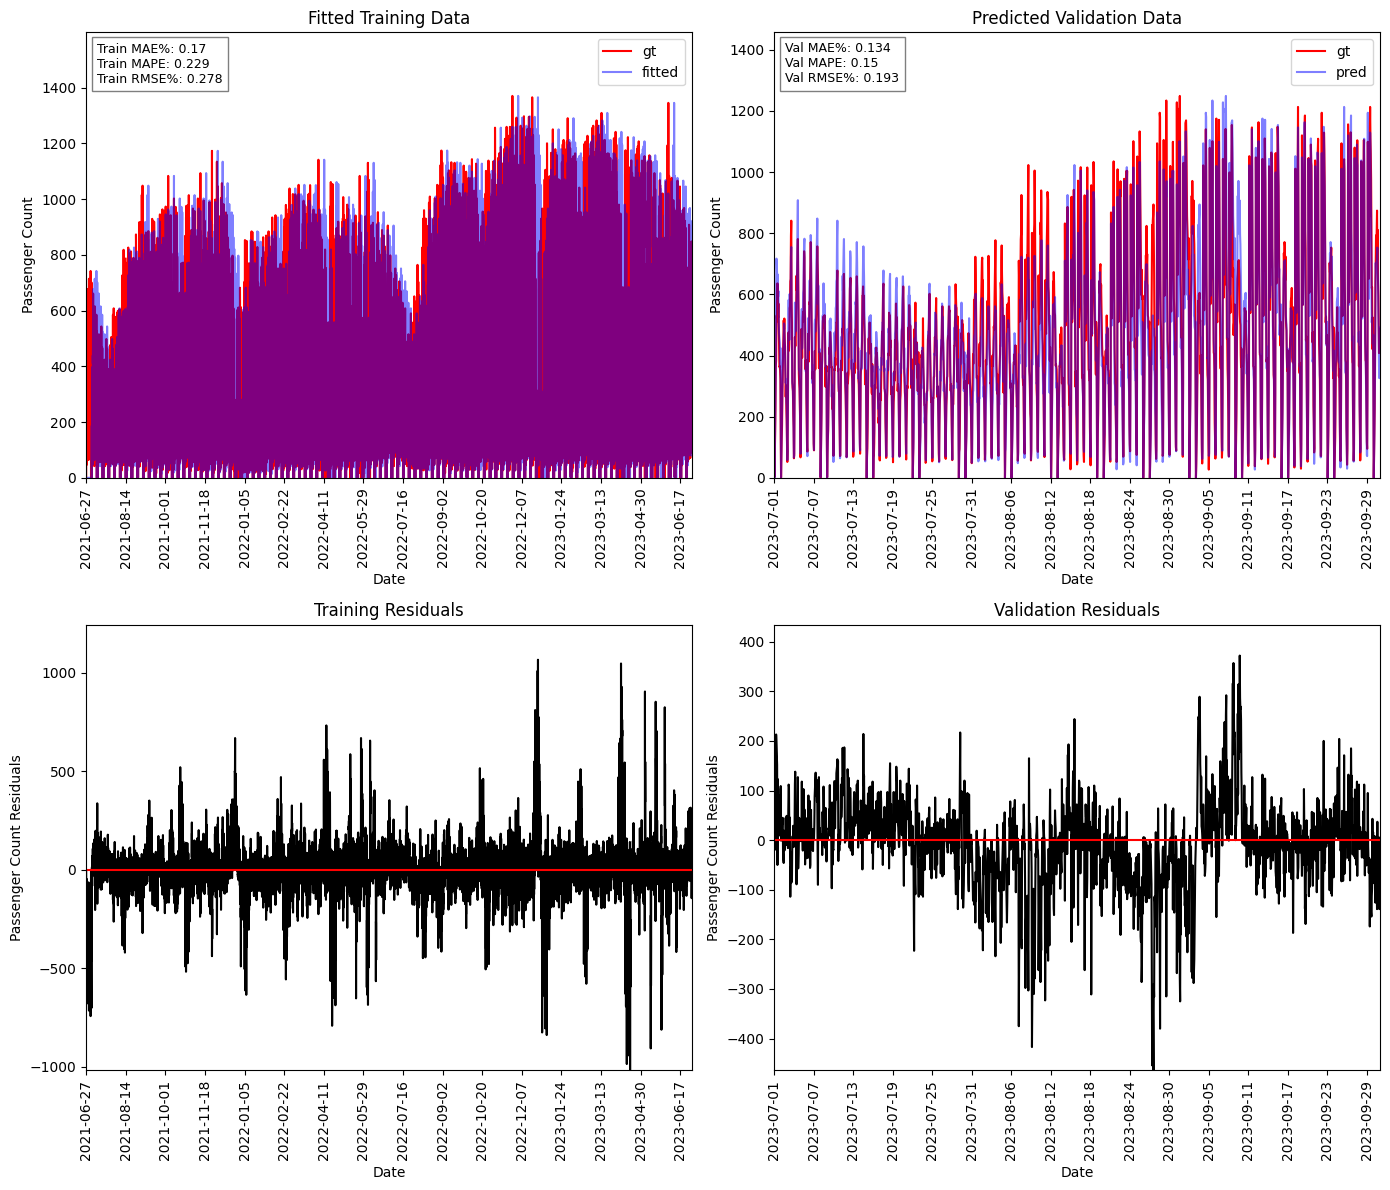

In [3]:
lookback = 140*agg # 140 * amount of observations per hour

timer = Time()
timer.start()
# same as past 140th observation
y_train_pred = y_train.shift(periods=lookback).fillna(0)
# concat train and val so lags are possible. Find same as past 140th observation.
y_val_pred = pd.concat([y_train, y_val]).shift(periods=lookback).fillna(0)[y_val.index]
print(timer.end())

# round and cut off train and val predictions
y_train_pred = y_train_pred.round()
y_train_pred[y_train_pred < 0] = 0
y_val_pred = y_val_pred.round()
y_val_pred[y_val_pred < 0] = 0


utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred,
                                  y_train_true=y_train, y_val_true=y_val,
                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

# Lasso

Execution time: 0.382 sec


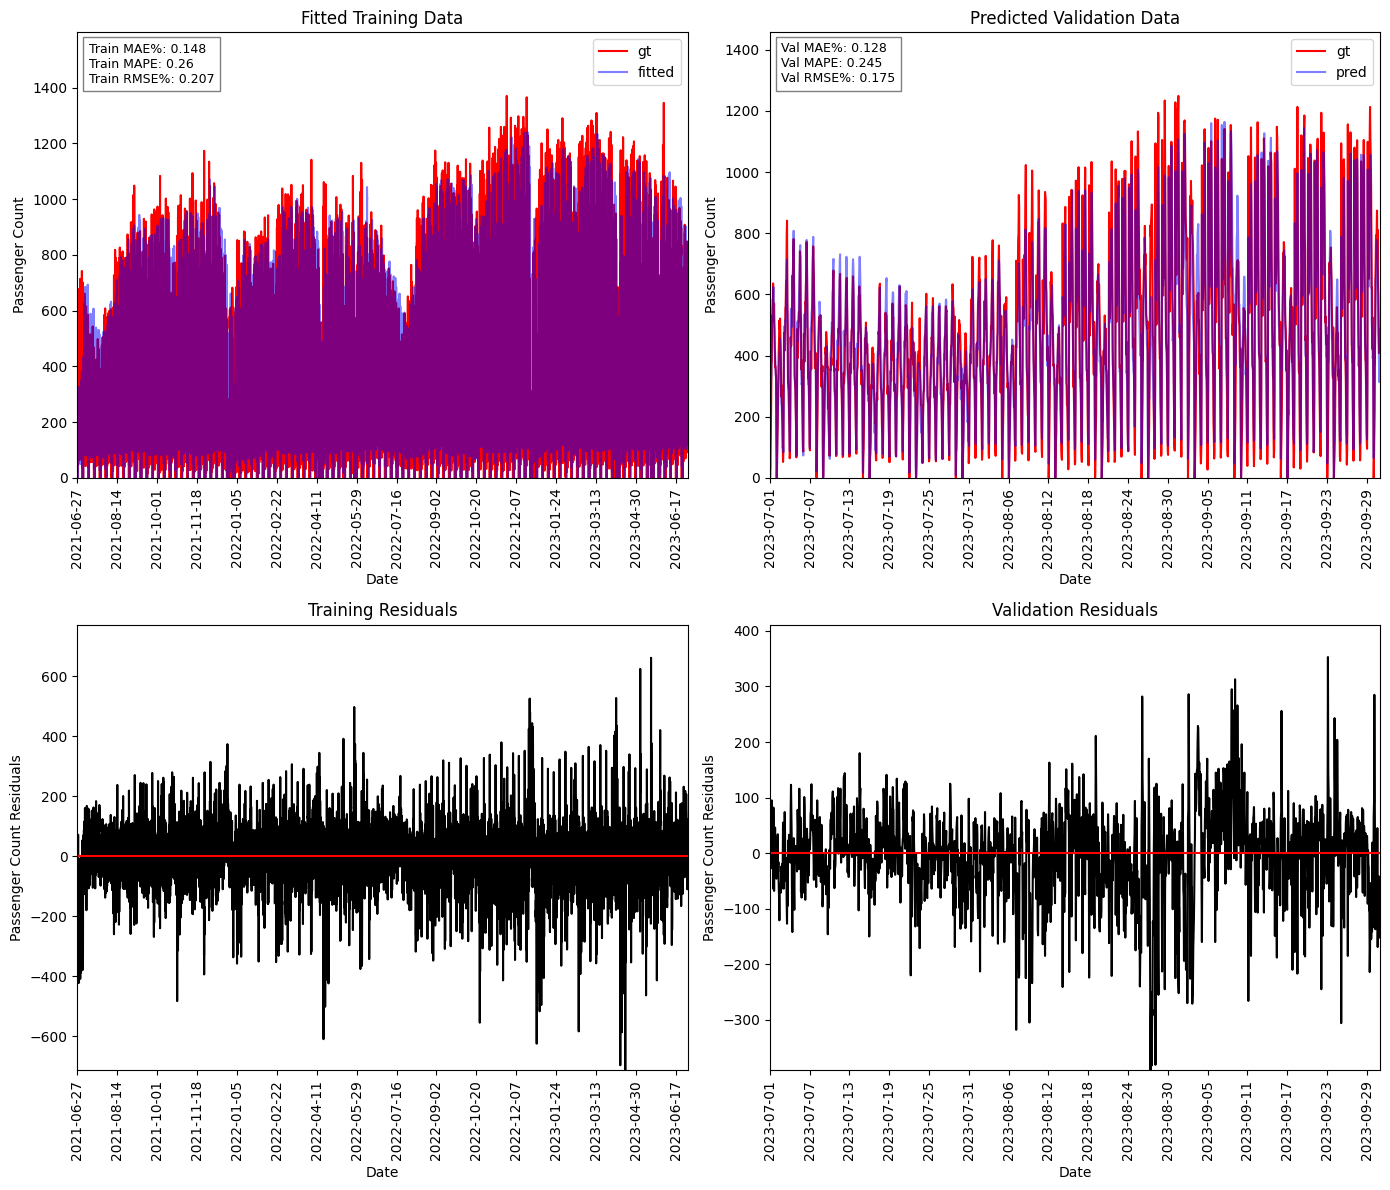

                            OLS Regression Results                            
Dep. Variable:     passengersBoarding   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     3482.
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:21:24   Log-Likelihood:                -87141.
No. Observations:               14680   AIC:                         1.743e+05
Df Residuals:                   14646   BIC:                         1.746e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  200.5475 

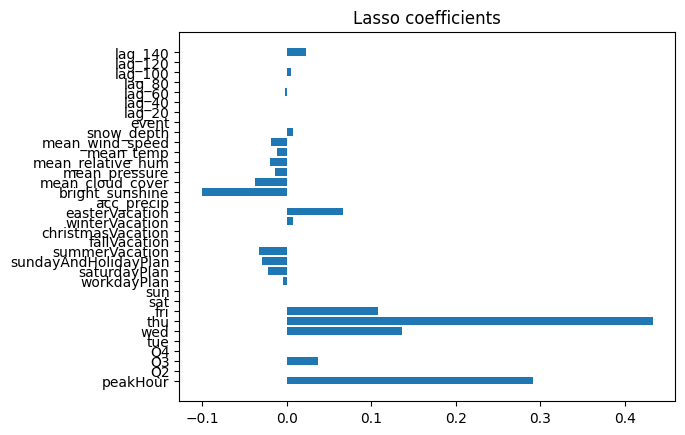

In [11]:
# fixed window 40 hours ahead
horizon = 40*agg

# best 60 min without diff
lags = [20, 40, 60, 80, 100, 120, 140]
differentiation = None
alpha = 0.01

# best 60 min with diff
#lags = [140]
#differentiation = 1
#alpha = 0.01

# best 30 min without diff
#lags = [40, 80, 120, 160, 200, 240, 280]
#differentiation = None
#alpha = 0.01

# best 30 min with diff
#lags = [2, 40, 80, 120, 160, 200, 240, 280]
#differentiation = 1
#alpha = 0.01

# best 15 min without diff
#lags = [80, 160, 240, 320, 400, 480, 560]
#differentiation = None
#alpha = 0.01

# best 15 min with diff
#lags = [4, 80, 160, 240, 320, 400, 480, 560]
#differentiation = 1
#alpha = 0.01

model = Lasso(alpha=alpha, fit_intercept=True, max_iter=1000)
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None#X_train.shape[0]
use_exog = True

model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
    differentiation=differentiation, lags=lags, window_type=window_type, window_size=window_size,
    horizon=horizon, use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model)

utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred,
                                  y_train_true=y_train, y_val_true=y_val,
                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])


# Use statsmodels to perform OLS regression and output summary
X_train_lagged = X_train.copy(deep=True)
if lags:
    for lag in lags:
        X_train_lagged[f'lag_{lag}'] = y_train.shift(periods=lag).fillna(0)
ols_model = sm.OLS(y_train, sm.add_constant(X_train_lagged)).fit()
print(ols_model.summary())

plt.barh(X_train_lagged.columns, model.coef_)
plt.title('Lasso coefficients')
plt.show()

# Lasso grid search

In [ ]:
##########
# Mangler: kør igennem, udvid grid search og gem værdier løbende for hver window type mv.
##########

horizon = 40*agg
bestMAE = 100000
laglist = [[1], [2], [3], [4], [5], [6], [7], [8], [20], [40], [60], [80], [100], [120], [140],
           [1, 20, 140], [1, 4, 7, 8, 20],
           [1, 20, 40, 60, 80, 100, 120, 140],
           [1, 2, 3, 4, 5, 6, 7, 8], [20, 40, 60, 80, 100, 120, 140]]

laglist = [[i*agg for i in templist] for templist in laglist]

for diff in [1, None]:
    for lags in laglist:
        for alpha in [0.3, 0.2, 0.1, 0.05, 0.01]:
            model = Lasso(alpha=alpha, fit_intercept=True, max_iter=1000)
            scalar = StandardScaler()
            exog_scalar = StandardScaler()

            window_type = 'fixed'
            window_size = None#X_train.shape[0]
            use_exog = True

            model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
                differentiation=diff, lags=lags, window_type=window_type, window_size=window_size,
                horizon=horizon, use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
                X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model)

            trainMAE = MAE(y=y_train, yhat=y_train_pred)
            valMAE = MAE(y=y_val, yhat=y_val_pred)
            if valMAE < bestMAE:
                bestMAE = valMAE
                print(alpha, diff, lags)
                print('train MAE%:', MAE(y=y_train, yhat=y_train_pred))
                print('train MAPE:', MAPE(y=y_train, yhat=y_train_pred))
                print('train RMSE%:', RMSE(y=y_train, yhat=y_train_pred))

                print('val MAE%:', MAE(y=y_val, yhat=y_val_pred))
                print('val MAPE:', MAPE(y=y_val, yhat=y_val_pred))
                print('val RMSE%:', RMSE(y=y_val, yhat=y_val_pred))

print('done')

Forecast iteration: 5


KeyboardInterrupt: 

Best 60min with 1-diff: alpha=0.01, diff=1, lag=[140]

Training: MAE: 0.168, MAPE: 0.32, RMSE: 0.238

Validation: MAE: 0.19, MAPE: 0.281, RMSE: 0.257


Best 60min without 1-diff: alpha=0.01, diff=None, lags=[20, 40, 60, 80, 100, 120, 140]

Training: MAE: 0.148, MAPE: 0.261, RMSE: 0.207

Validation: MAE: 0.128, MAPE: 0.249, RMSE: 0.175

Best 30min with 1-diff: alpha=0.01, diff=1, lags=[2, 40, 80, 120, 160, 200, 240, 280]

Training: MAE: 0.156, MAPE: 0.414, RMSE: 0.216

Validation: MAE: 0.307, MAPE: 0.631, RMSE: 0.39


Best 30min without 1-diff: alpha=0.01, diff=None, lags=[40, 80, 120, 160, 200, 240, 280]

Training: MAE: 0.164, MAPE: 0.45, RMSE: 0.228

Validation: MAE: 0.143, MAPE: 0.389, RMSE: 0.195

Best 15min with 1-diff: alpha=0.01, diff=1, lag=[4, 80, 160, 240, 320, 400, 480, 560]

Training: MAE: 0.180, MAPE: 0.333, RMSE: 0.247

Validation: MAE: 0.465, MAPE: 0.802, RMSE: 0.581


Best 15min without 1-diff: alpha=0.01 , diff=None, lag=[80, 160, 240, 320, 400, 480, 560]

Training: MAE: 0.188, MAPE: 0.368, RMSE: 0.257

Validation: MAE: 0.167, MAPE: 0.316, RMSE: 0.226